In [1]:
# ==============================================================================
# --- 1. Import Libraries ---
# ==============================================================================
# For enhanced Jupyter Notebook display settings
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 80% !important; }</style>"))

# Core libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
from sklearn.mixture import GaussianMixture
from scipy import linalg
from scipy.stats import spearmanr
import matplotlib as mpl

In [16]:
# ==============================================================================
# --- 2. Load and Process Hi-C Data (Soybean Example) ---
# ==============================================================================

# Hi-C path (Soybean Example)
hic_path = "../data/soybean_leaf_HiC.hiccups_loops.fdr0.1.bedpe"
#hic_path = "../data/rice_leaf_HiC.hiccups_loops.fdr0.1.bedpe"
#hic_path = "../data/maize_HiC_leaf_loops.bedpe"

species_name = os.path.basename(hic_path).split('_')[0].capitalize()


# Load the data
# If it's tab-delimited, use sep='\t'.
hic_data = pd.read_csv(hic_path, sep=r'\s+', engine="python")

# Keep only the first 6 columns and assign clear names
hic_data = hic_data.iloc[:, :6]
hic_data.columns = ['chr1', 's1', 'e1', 'chr2', 's2', 'e2']

# Remove duplicates and calculate genomic distance
n_dups = hic_data.duplicated().sum()
print(f"Hi-C duplicates removed: {n_dups}")
hic_data = hic_data.drop_duplicates()
hic_data['distance'] = abs(((hic_data['s1'] + hic_data['e1']) // 2) -
                           ((hic_data['s2'] + hic_data['e2']) // 2))

print("\nProcessed Hi-C data sample:")
print(hic_data.head())

Hi-C duplicates removed: 0

Processed Hi-C data sample:
   chr1        s1        e1  chr2        s2        e2  distance
0  GM10  42440000  42445000  GM10  42475000  42480000     35000
1  GM10  22860000  22865000  GM10  22900000  22905000     40000
2  GM10  17305000  17310000  GM10  17515000  17520000    210000
3  GM10  10315000  10320000  GM10  10360000  10365000     45000
4  GM10  43250000  43255000  GM10  43290000  43295000     40000


In [17]:
# ==============================================================================
# --- 3. Helper Function for Binning ---
# ==============================================================================

def bin_and_count_distances(df: pd.DataFrame, distance_col: str = 'distance', num_bins: int = 100) -> pd.DataFrame:
    """Bins distance data logarithmically and calculates counts per bin."""
    if df.empty or distance_col not in df.columns:
        return pd.DataFrame()
        
    positive_distances = df[df[distance_col] > 0][distance_col]
    if positive_distances.empty:
        return pd.DataFrame()

    min_dist, max_dist = positive_distances.min(), positive_distances.max()
    bins = np.logspace(np.log10(min_dist), np.log10(max_dist), num=num_bins)
    labels = pd.cut(positive_distances, bins=bins, include_lowest=True, right=True)
    counts = labels.value_counts().sort_index()
    
    binned_df = pd.DataFrame({'count': counts.values})
    # Use the geometric mean for the bin midpoint, which is appropriate for log-spaced bins
    binned_df['bin_midpoint'] = [np.sqrt(interval.left * interval.right) for interval in counts.index]
    
    return binned_df.dropna()

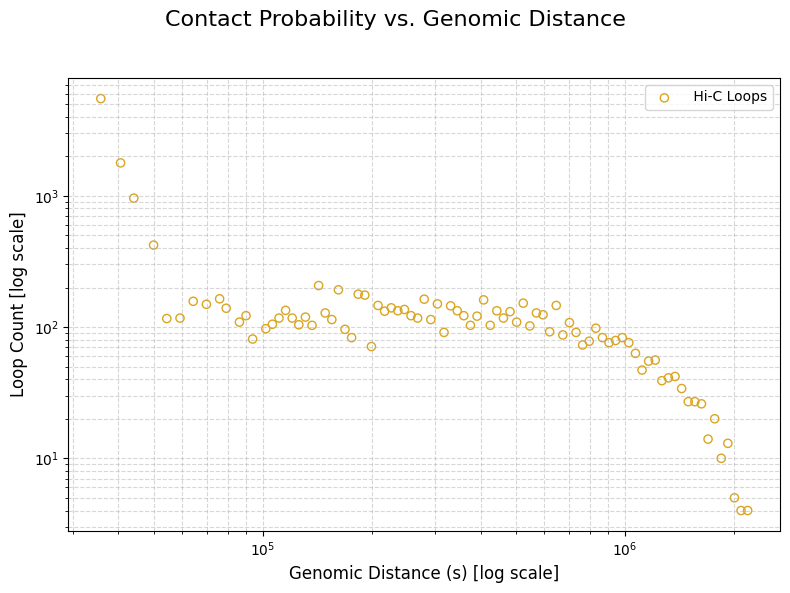

In [18]:
# ==============================================================================
# --- 4. Plot the Contact Decay Profile ---
# ==============================================================================

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
fig.suptitle('Contact Probability vs. Genomic Distance', fontsize=16)

# Bin the data for plotting
binned_data = bin_and_count_distances(hic_data)
df_plot = binned_data[binned_data['count'] > 0]

# Create the scatter plot
ax.scatter(df_plot['bin_midpoint'], df_plot['count'], 
           facecolors='none', edgecolors='goldenrod', s=35, label=' Hi-C Loops')

# Set log scales and labels
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Genomic Distance (s) [log scale]', fontsize=12)
ax.set_ylabel('Loop Count [log scale]', fontsize=12)
ax.grid(True, which="both", ls="--", alpha=0.5)
ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect to accommodate the suptitle
plt.show()


--- Determining Optimal Number of GMM Components for Soybean ---
Testing GMMs with 1 to 5 components...

Model with n=3 (BIC=34.02) is not substantially worse than n=4 (BIC=30.49).
Difference: 3.53. Applying principle of parsimony.

Model with n=2 is substantially worse. Stopping search.


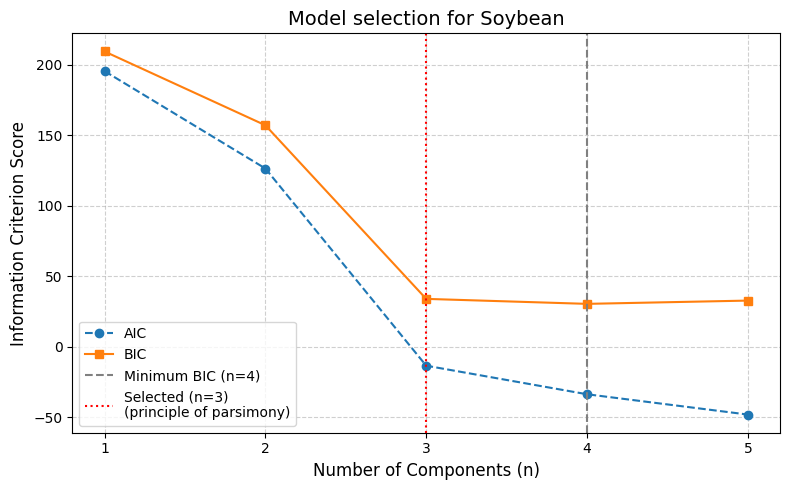


--- Summary of Optimal Number of components ---
For Soybean, the selected model has 3 component(s) with a final BIC of 34.02.


In [19]:
# ==============================================================================
# --- 5. Determine Optimal GMM Components using AIC/BIC ---
# ==============================================================================
print(f"\n--- Determining Optimal Number of GMM Components for {species_name} ---")

# 1. Prepare Data for GMM fitting
# Using num_bins=150 to match the original analysis for reproducibility.
binned_data_gmm = bin_and_count_distances(hic_data, num_bins=150)
df_fit = binned_data_gmm[binned_data_gmm['count'] > 0].copy()

log_x_data = np.log10(df_fit['bin_midpoint'].values)
log_y_data = np.log10(df_fit['count'].values)
X_data = np.vstack([log_x_data, log_y_data]).T

# 2. Fit GMMs for a range of components and calculate AIC/BIC
n_components_range = range(1, 6)
aic_scores = []
bic_scores = []

print("Testing GMMs with 1 to 5 components...")
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm.fit(X_data)
    aic_scores.append(gmm.aic(X_data))
    bic_scores.append(gmm.bic(X_data))

# 3. Select final model based on BIC and the principle of parsimony
min_bic_idx = np.argmin(bic_scores)
technical_optimal_n = min_bic_idx + 1
parsimonious_n_idx = min_bic_idx

bic_threshold = 25.0 

for i in range(min_bic_idx - 1, -1, -1):
    bic_complex = bic_scores[parsimonious_n_idx]
    bic_simple = bic_scores[i]
    bic_difference = bic_simple - bic_complex
    
    if bic_difference < bic_threshold:
        print(f"\nModel with n={i+1} (BIC={bic_simple:.2f}) is not substantially worse than n={parsimonious_n_idx+1} (BIC={bic_complex:.2f}).")
        print(f"Difference: {bic_difference:.2f}. Applying principle of parsimony.")
        parsimonious_n_idx = i
    else:
        print(f"\nModel with n={i+1} is substantially worse. Stopping search.")
        break

optimal_n = parsimonious_n_idx + 1

# 4. Plot the AIC/BIC scores
fig_bic, ax_bic = plt.subplots(figsize=(8, 5))
ax_bic.plot(n_components_range, aic_scores, marker='o', linestyle='--', label='AIC')
ax_bic.plot(n_components_range, bic_scores, marker='s', linestyle='-', label='BIC')

ax_bic.axvline(technical_optimal_n, color='gray', linestyle='--', label=f'Minimum BIC (n={technical_optimal_n})')
ax_bic.axvline(optimal_n, color='red', linestyle=':', label=f'Selected (n={optimal_n})\n(principle of parsimony)')

# Formatting
ax_bic.set_title(f'Model selection for {species_name}', fontsize=14)
ax_bic.set_xlabel('Number of Components (n)', fontsize=12)
ax_bic.set_ylabel('Information Criterion Score', fontsize=12)
ax_bic.set_xticks(n_components_range)
ax_bic.grid(True, linestyle='--', alpha=0.6)
ax_bic.legend()
plt.tight_layout()
plt.show()

# --- 5. Print the final summary ---
print("\n--- Summary of Optimal Number of components ---")
print(f"For {species_name}, the selected model has {optimal_n} component(s) with a final BIC of {bic_scores[parsimonious_n_idx]:.2f}.")

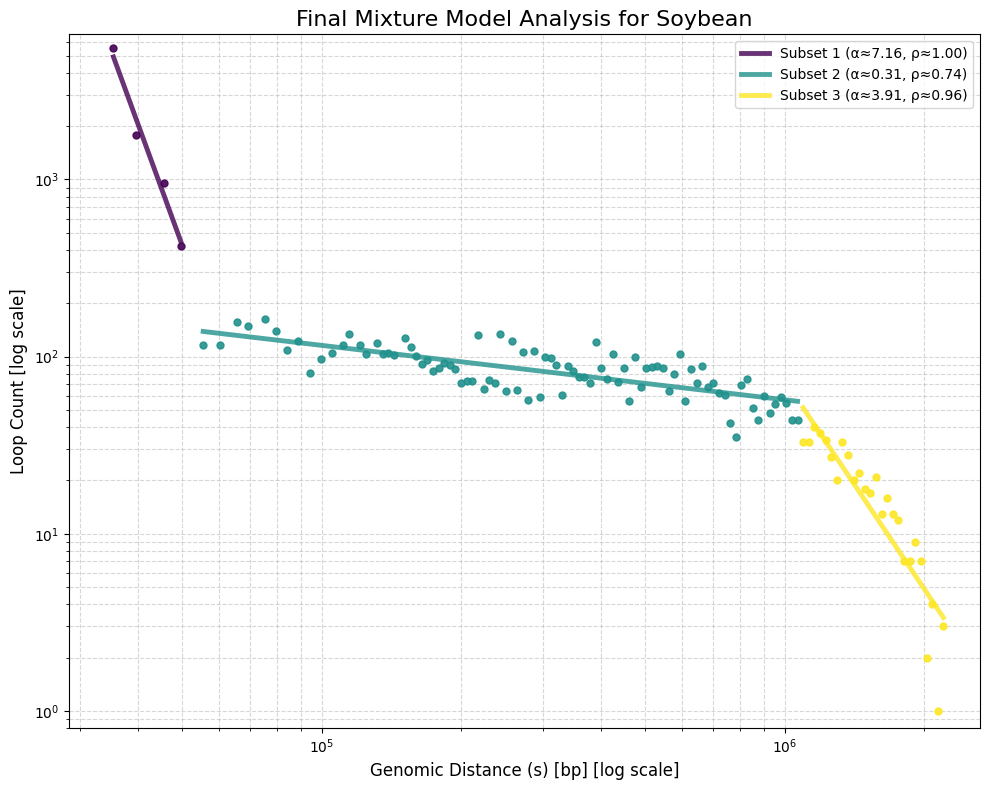

In [20]:
# ==============================================================================
# --- 6. Fit Final GMM, Calculate Parameters, and Plot ---
# ==============================================================================

# 1. Fit the final GMM with the selected number of components
final_gmm = GaussianMixture(n_components=optimal_n, covariance_type='full', random_state=0)
labels = final_gmm.fit(X_data).predict(X_data)

# 2. Sort components by their position along the x-axis (genomic distance)
component_properties = []
for i in range(optimal_n):
    mean = final_gmm.means_[i]
    cov = final_gmm.covariances_[i]
    slope = cov[0, 1] / cov[0, 0]
    intercept = mean[1] - slope * mean[0]
    component_properties.append({
        'mean_x': mean[0], 'mean': mean, 'cov': cov,
        'original_label': i, 'slope': slope, 'intercept': intercept
    })
sorted_components = sorted(component_properties, key=lambda p: p['mean_x'])

# 3. Plot the final GMM decomposition
fig_final, ax_final = plt.subplots(figsize=(10, 8))
component_colors = plt.cm.viridis(np.linspace(0, 1, optimal_n))
final_results_list = []

for i, component in enumerate(sorted_components):
    original_label = component['original_label']
    component_mask = (labels == original_label)
    color = component_colors[i]
    
    ax_final.scatter(x=10**X_data[component_mask, 0], y=10**X_data[component_mask, 1],
                     color=color, s=25, alpha=0.9, zorder=2)
    
    slope, intercept = component['slope'], component['intercept']
    component_log_x = X_data[component_mask, 0]
    log_x_range = np.linspace(component_log_x.min(), component_log_x.max(), 100)
    log_y_range = slope * log_x_range + intercept
    
    y_actual_component = X_data[component_mask, 1]
    y_pred_component = slope * X_data[component_mask, 0] + intercept
    if len(y_actual_component) > 1:
        rho, _ = spearmanr(y_actual_component, y_pred_component)
    else:
        rho = np.nan

    ax_final.plot(10**log_x_range, 10**log_y_range, color=color, linewidth=3.5,
                  label=f'Subset {i+1} (α≈{-slope:.2f}, ρ≈{rho:.2f})', zorder=3, alpha=0.8)

    final_results_list.append({
        'Species': species_name,
        'Subset': f'S{i+1}',
        'pi_i (weight)': final_gmm.weights_[original_label],
        'alpha_i (exponent)': -slope,
        'beta_i (scaling_factor)': 10**intercept
    })

ax_final.set_xscale('log')
ax_final.set_yscale('log')
ax_final.set_title(f'Final Mixture Model Analysis for {species_name}', fontsize=16)
ax_final.set_ylabel('Loop Count [log scale]', fontsize=12)
ax_final.set_xlabel('Genomic Distance (s) [bp] [log scale]', fontsize=12)
ax_final.grid(True, which="both", ls="--", alpha=0.5)
ax_final.legend(fontsize=10)

min_x, max_x = 10**X_data[:, 0].min(), 10**X_data[:, 0].max()
min_y, max_y = 10**X_data[:, 1].min(), 10**X_data[:, 1].max()
ax_final.set_xlim(min_x * 0.8, max_x * 1.2)
ax_final.set_ylim(min_y * 0.8, max_y * 1.2)

plt.tight_layout()
plt.show()

In [21]:
# ==============================================================================
# --- 7. Display and Save Final Parameters ---
# ==============================================================================

results_df = pd.DataFrame(final_results_list)

# 1. Display Formatted Summary
print(f"\n==================== {species_name.upper()} ====================")
print(f"Mixture Model Fit (K={optimal_n}):")

for i, row in results_df.iterrows():
    pi = row['pi_i (weight)']
    alpha = row['alpha_i (exponent)']
    beta = row['beta_i (scaling_factor)']
    print(f"\n  Subset {i+1}:")
    print(f"    π = {pi:.4f}")
    print(f"    α = {alpha:.4f}")
    print(f"    β = {beta:.3e}")

# 2. Display Transition Points
print(f"\n--- Transition Points ---")
if optimal_n > 1:
    for i in range(optimal_n - 1):
        comp_i = sorted_components[i]
        comp_j = sorted_components[i+1]
        slope_i, intercept_i = comp_i['slope'], comp_i['intercept']
        slope_j, intercept_j = comp_j['slope'], comp_j['intercept']
        
        if (slope_i - slope_j) == 0:
            print(f"  Transition between Subset {i+1} and {i+2}: Parallel slopes, no unique transition point.")
            continue
        
        log_s_transition = (intercept_j - intercept_i) / (slope_i - slope_j)
        s_transition_kb = (10**log_s_transition) / 1000
        print(f"  Transition between Subset {i+1} and Subset {i+2}: {s_transition_kb:.1f} kb")
else:
    print("  Only one component, no transition points to calculate.")
print(f"\n==================== {species_name.upper()} ====================")

# 3. Save Penalty Function Parameters to File
output_dir = "../penalty_functions/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_filename = f"{species_name.lower()}_penalty_parameters.tsv"
output_path = os.path.join(output_dir, output_filename)

try:
    results_df.to_csv(output_path, sep='\t', index=False, float_format="%.4f")
    print(f"\n✅ Penalty function parameters successfully saved to: {output_path}")
except Exception as e:
    print(f"\n❌ ERROR: Could not save the file. Reason: {e}")


==================== SOYBEAN ====================
Mixture Model Fit (K=3):

  Subset 1:
    π = 0.0347
    α = 7.1609
    β = 1.883e+36

  Subset 2:
    π = 0.7430
    α = 0.3072
    β = 3.977e+03

  Subset 3:
    π = 0.2222
    α = 3.9098
    β = 2.111e+25

--- Transition Points ---
  Transition between Subset 1 and Subset 2: 58.6 kb
  Transition between Subset 2 and Subset 3: 1072.4 kb

==================== SOYBEAN ====================

✅ Penalty function parameters successfully saved to: ../penalty_functions/soybean_penalty_parameters.tsv
